# HW4: Recurrent Neural Networks
Welcome to HomeWork 4  









In [1]:
# !pip3 install fastquant

In [2]:
from fastquant import get_crypto_data
import os.path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#load 1000 days ETH/BTC data 
crypto_ETH = get_crypto_data("ETH/USDT", "2018-09-08", "2021-06-04")
crypto_BTC = get_crypto_data("BTC/USDT", "2018-09-08", "2021-06-04")


Text(0.5, 1.0, 'Daily Closing Price of ETH/USDT')

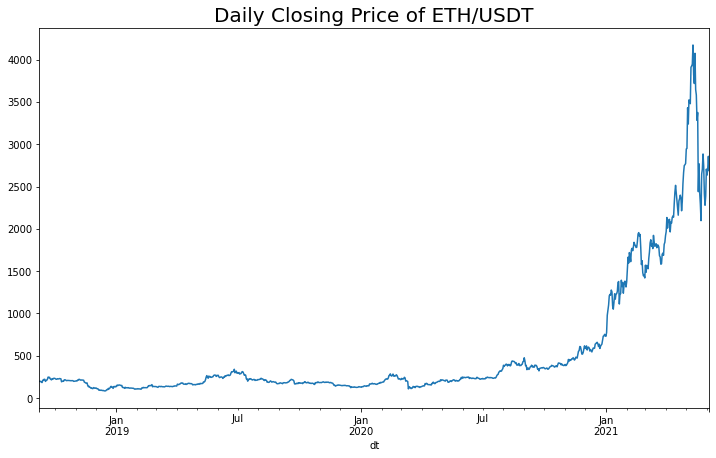

In [3]:
from matplotlib import pyplot as plt
crypto_ETH.close.plot(figsize=(12, 7))
plt.title("Daily Closing Price of ETH/USDT", fontsize=20)

In [4]:
#make sequence of data (for example we consider 2 sequence for days to predict 3th day close price)
def sliding_windows(input_data, labels, seq_length):
    inout_seq = []
    L = len(input_data)
    for i in range(L-seq_length):
        train_seq = input_data[i:i+seq_length]
        train_label = labels[i+seq_length:i+seq_length+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


In [5]:

seq_len = 2

crypto_BTC.head()
crypto_ETH.head()

#in this section we normalize and export some columns that we need
dataset_len = len(crypto_ETH)
trainingset_len = round((dataset_len*95)/100)
testset_len = round((dataset_len*5)/100)

crypto_BTC = crypto_BTC.rename(columns={"low": "lowBTC", "high": "highBTC", "close": "closeBTC", "open": "openBTC"})[['lowBTC', 'highBTC', 'closeBTC', 'openBTC']]
dataset = pd.concat([crypto_ETH, crypto_BTC], axis=1)
trainingset = dataset[0 : trainingset_len]
testset = dataset[trainingset_len : dataset_len]


trainingset_x = trainingset[['open', 'low', 'high', 'close', 'lowBTC', 'highBTC', 'closeBTC', 'openBTC']]
trainingset_y = trainingset[['close']]

testset_x = testset[['open', 'low', 'high', 'close', 'lowBTC', 'highBTC', 'closeBTC', 'openBTC']]
testset_y = testset[['close']]


sc = MinMaxScaler()
trainingset_x = sc.fit_transform(trainingset_x)
trainingset_y = sc.fit_transform(trainingset_y)

testset_x = sc.fit_transform(testset_x)
testset_y = sc.fit_transform(testset_y)


#convert data to torch acceptable data form
trainingset_x = torch.FloatTensor(trainingset_x)
trainingset_y = torch.FloatTensor(trainingset_y)

testset_x = torch.FloatTensor(testset_x)
testset_y = torch.FloatTensor(testset_y)


#use sequence function to zip input and label for each 2 sequence
trainingset = sliding_windows(trainingset_x, trainingset_y, seq_len)
testset = sliding_windows(testset_x, testset_y, seq_len)


In [6]:

num_epochs = 201
learning_rate = 0.001

#input feature size
input_size = 8

#each layer has 100 nodes
hidden_size = 100

#2 layers
num_layers = 2

#output size
num_classes = 1


class RNN_LSTM(nn.Module):
    def __init__(self, input_size=8, hidden_size=100, num_layers=1, num_classes=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, num_classes)

       
    def forward(self, input_seq):
        hidden_cell = (torch.zeros(self.num_layers, 1, self.hidden_size),
                            torch.zeros(self.num_layers, 1, self.hidden_size))

        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

        

Epoch:0, loss:14.918%
Epoch:50, loss:10.379%
Epoch:100, loss:3.394%
Epoch:150, loss:0.636%
Epoch:200, loss:0.805%
 ======================= make prediction ======================= 
test data 1:, loss:13.657%
test data 2:, loss:9.71%
test data 3:, loss:5.246%
test data 4:, loss:5.74%
test data 5:, loss:6.076%
test data 6:, loss:9.779%
test data 7:, loss:11.708%
test data 8:, loss:5.234%
test data 9:, loss:3.869%
test data 10:, loss:1.198%
test data 11:, loss:0.165%
test data 12:, loss:2.887%
test data 13:, loss:3.844%
test data 14:, loss:1.227%
test data 15:, loss:3.273%
test data 16:, loss:17.638%
test data 17:, loss:9.348%
test data 18:, loss:4.746%
test data 19:, loss:5.678%
test data 20:, loss:4.359%
test data 21:, loss:15.14%
test data 22:, loss:0.197%
test data 23:, loss:1.827%
test data 24:, loss:6.648%
test data 25:, loss:19.237%
test data 26:, loss:13.683%
test data 27:, loss:17.201%
test data 28:, loss:17.462%
test data 29:, loss:7.573%
test data 30:, loss:9.683%
test data 31:,

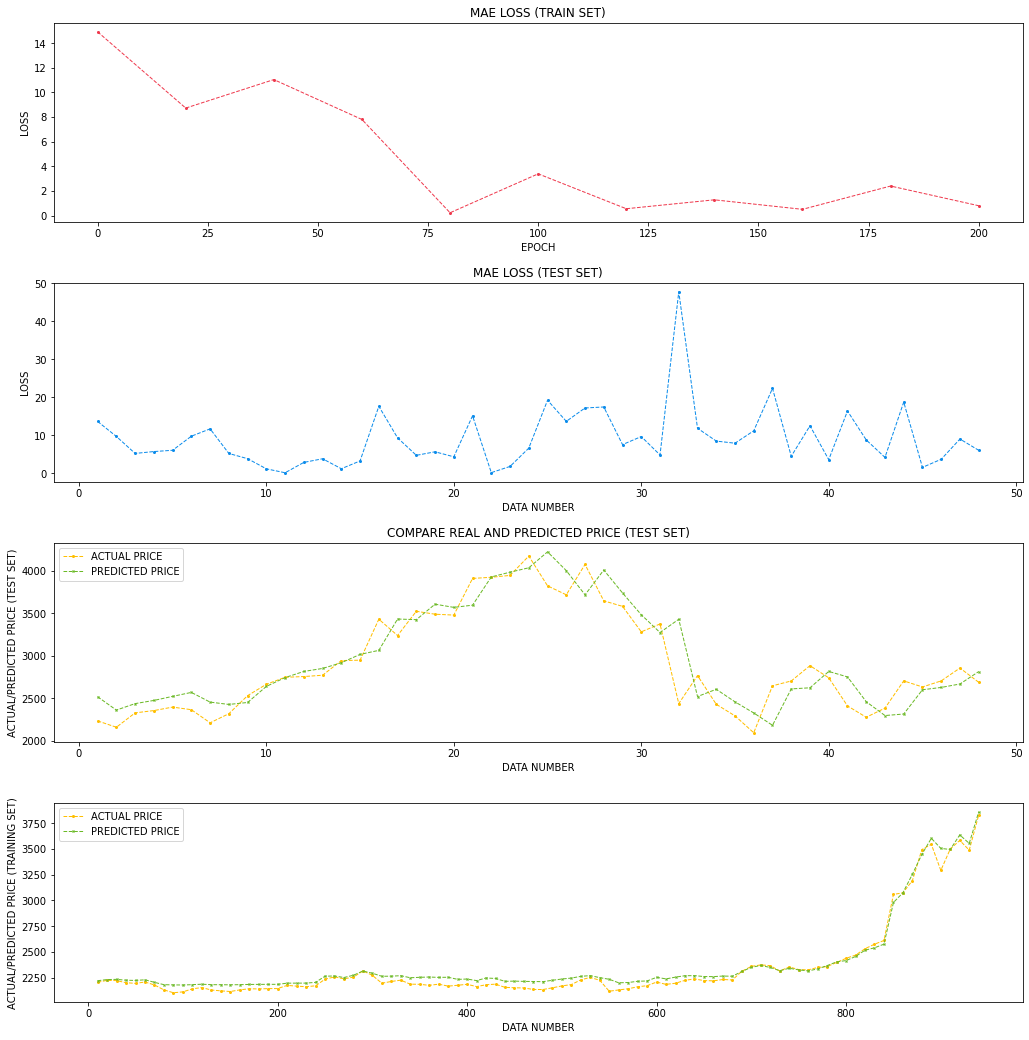

In [7]:
model_parameters_path = './model_parameters.pt'
if os.path.isfile(model_parameters_path):
    model = torch.load(model_parameters_path)
    model.eval()
else:
    
    #create object of model class
    model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes )

    #MAE loss funciton
    loss_func = nn.L1Loss()

    #configure optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
    fig.tight_layout(pad=4)

    #configure subplots for show loss and predictions
    axes[0].set_title('MAE LOSS (TRAIN SET)')
    axes[1].set_title('MAE LOSS (TEST SET)')
    axes[2].set_title('COMPARE REAL AND PREDICTED PRICE (TEST SET)')

    axes[0].set_xlabel('EPOCH')
    axes[0].set_ylabel('LOSS')

    axes[1].set_xlabel('DATA NUMBER')
    axes[1].set_ylabel('LOSS')

    axes[2].set_xlabel('DATA NUMBER')
    axes[2].set_ylabel('ACTUAL/PREDICTED PRICE (TEST SET)')

    axes[3].set_xlabel('DATA NUMBER')
    axes[3].set_ylabel('ACTUAL/PREDICTED PRICE (TRAINING SET)')

    losses = []
    epochs = []

    #lets learn
    for epoch in range(num_epochs):
        for seq, labels in trainingset:

            optimizer.zero_grad()

            output = model(seq)

            loss = loss_func(output, labels)
            loss.backward()

            optimizer.step()



        if epoch % 20 == 0:
            losses.append(round(loss.item()*100,5))
            epochs.append(epoch)

        if epoch % 50 == 0:
            print("Epoch:"+str(epoch)+", loss:"+ str(round(loss.item()*100,3))+"%" )



    #show training set losses on plot
    axes[0].plot(epochs, losses, color="#EF394D", linewidth=1, markersize=2, linestyle='dashed', marker='o')


    torch.save(model, model_parameters_path)



print(' ======================= make prediction ======================= ')
model.eval()

counter = 0
counters = []
losses = []
actual_price = []
predicted_price = []

#make prediction on testset
for seq, labels in testset:

    with torch.no_grad():
        output = model(seq)
        loss = loss_func(output, labels)
        predicted_price.append(output)
        actual_price.append(labels)
        losses.append(round(loss.item()*100,5))
        counter+=1
        counters.append(counter)


    print("test data "+str(counter)+ ":, loss:"+ str(round(loss.item()*100,3))+"%" )

    
axes[1].plot(counters, losses, color="#0B8CEB", linewidth=1, markersize=2, linestyle='dashed', marker='o')

actual_price = actual_predictions = sc.inverse_transform(np.array(actual_price).reshape(-1, 1))
predicted_price = actual_predictions = sc.inverse_transform(np.array(predicted_price).reshape(-1, 1))

axes[2].plot(counters, actual_price, label='ACTUAL PRICE', color="#ffbf00", linewidth=1, markersize=2, linestyle='dashed', marker='o')
axes[2].plot(counters, predicted_price,  label='PREDICTED PRICE',color="#6BB926", linewidth=1, markersize=2, linestyle='dashed', marker='x')
axes[2].legend(loc="upper left")
    
    
counter = 0
counters = []    
actual_price = []
predicted_price = []

#use prediction form to show predicted values for training set on plot
for seq, labels in trainingset:

    with torch.no_grad():
        output = model(seq)
        counter+=1
        if counter % 10 == 0:
            counters.append(counter)
            predicted_price.append(output)
            actual_price.append(labels)

    
    

actual_price = actual_predictions = sc.inverse_transform(np.array(actual_price).reshape(-1, 1))
predicted_price = actual_predictions = sc.inverse_transform(np.array(predicted_price).reshape(-1, 1))

axes[3].plot(counters, actual_price, label='ACTUAL PRICE', color="#ffbf00", linewidth=1, markersize=2, linestyle='dashed', marker='o')
axes[3].plot(counters, predicted_price,  label='PREDICTED PRICE',color="#6BB926", linewidth=1, markersize=2, linestyle='dashed', marker='x')
axes[3].legend(loc="upper left")
      

plt.show()

#you can see plots on end of prediction loss results